In [1]:
!nvidia-smi

Sat May  4 07:46:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

The following code to package is a Jupyter Notebook extension to display information about the environment,
which incluse the version of Python installed packages, hostname, and date.

In [2]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00


In [3]:

!pip install transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.25.2
pandas      : 2.0.3
torch       : 2.2.1+cu121
transformers: 4.40.1



In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,TFBertModel
from transformers import XLMRobertaTokenizer
from transformers import RobertaModel, AutoModel,RobertaTokenizer, AutoTokenizer,AutoConfig,XLMRobertaModel
from transformers import XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup,XLMRobertaModel

#new Added data


from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data EDA

The data is loaded manually from my computer to corlab. I already downloaded  the tweet from their github at https://github.com/afrisenti-semeval/afrisent-semeval-2023
repository and set it on my computer. The data is divided into two set train , test, dev and the ha_dev_gold_label.tsv with level positive, negative and Neutral.

In [6]:
df = pd.read_csv('sen_1k.csv')


In [7]:
df.head()

,text,label
0,I knew it আমি যদি work hard করি I will get pr...,Positive
1,I still can't believe that আমার সবচেয়ে কাছের ...,Positive
2,The সুন্দর sunset has made my বাজে দিন into ...,Positive
3,The dog was so ভালো that I can't do anything ...,Positive
4,I really love to bake cookies and ভাগ করে দেই ...,Positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1007 non-null   object
 1   label   1007 non-null   object
dtypes: object(2)
memory usage: 15.9+ KB


In [9]:
df =df.rename(columns={"text":'tweet'})
df.head(2)

,tweet,label
0,I knew it আমি যদি work hard করি I will get pr...,Positive
1,I still can't believe that আমার সবচেয়ে কাছের ...,Positive


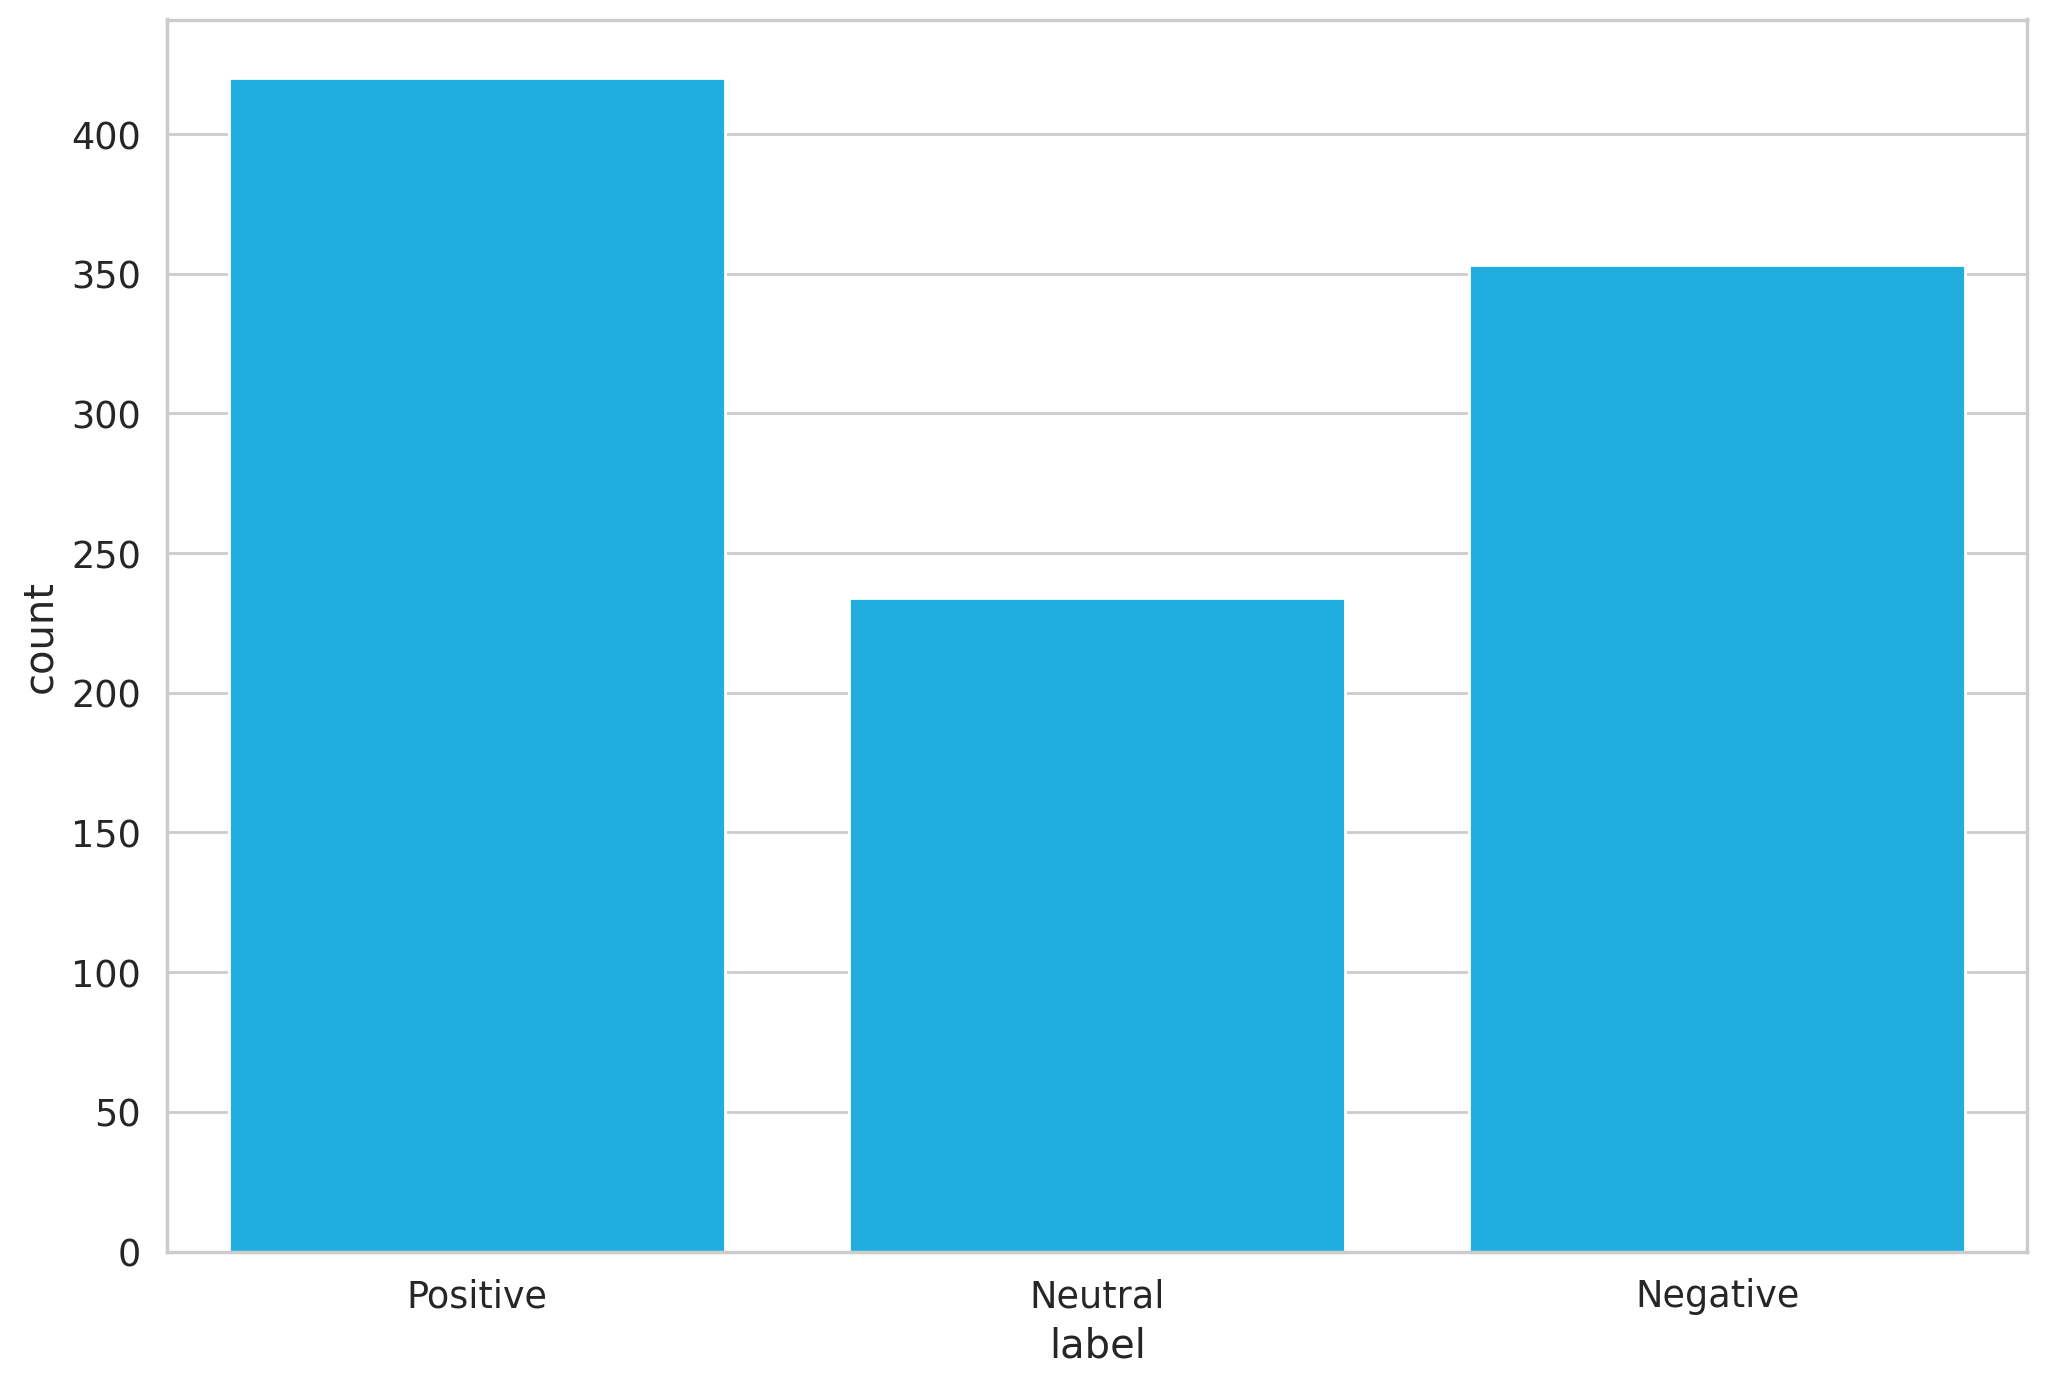

In [10]:
ax =sns.countplot(x=df["label"])

In [11]:
df['label'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [12]:
class_mapping = {'Negative':0,'Neutral':1,'Positive':2}
df['label'] = df['label'].map(class_mapping)
class_names =['Negative','Neutral','Positive']

In [13]:
df['label'].value_counts()

label
2    420
0    353
1    234
Name: count, dtype: int64

In [14]:
df['label'].unique()

array([2, 1, 0])

In [15]:
df['label'].isnull().sum()

0

In [16]:
df.count()

tweet    1007
label    1007
dtype: int64

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). Transformer requires even more attention. Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides a wide variety of Transformer models. It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!lifting for us!


In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'


Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
#tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
#tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
#MODEL = "Davlan/naija-twitter-sentiment-afriberta-large"
#tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

We'll use this text to understand the tokenization process:

In [19]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):
tokens will  used to tokenize the input text sample_txt into a list of subwords or tokens.
This process splits the text into individual words and subwords, as per the vocabulary of the tokenizer
tokens_ids will use to convert the list of tokens into a list of token IDs, where each token is represented as a unique integer.

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [20]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'st', '##uck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [12242, 10134, 146, 12469, 17555, 136, 146, 10392, 28780, 31746, 10160, 11816, 10142, 123, 20750, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [21]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [22]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

The mdoel understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  padding=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2697: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [26]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

18


tensor([  101, 12242, 10134,   146, 12469, 17555,   136,   146, 10392, 28780,
        31746, 10160, 11816, 10142,   123, 20750,   119,   102])

The attention mask has the same length:

In [27]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

18


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

We can inverse the tokenization to have a look at the special tokens:

In [28]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'st',
 '##uck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [29]:
token_lens = []

for txt in df.tweet:
  tokens = tokenizer.encode(txt, max_length=512, truncation= True)
  token_lens.append(len(tokens))

and plot the distribution:

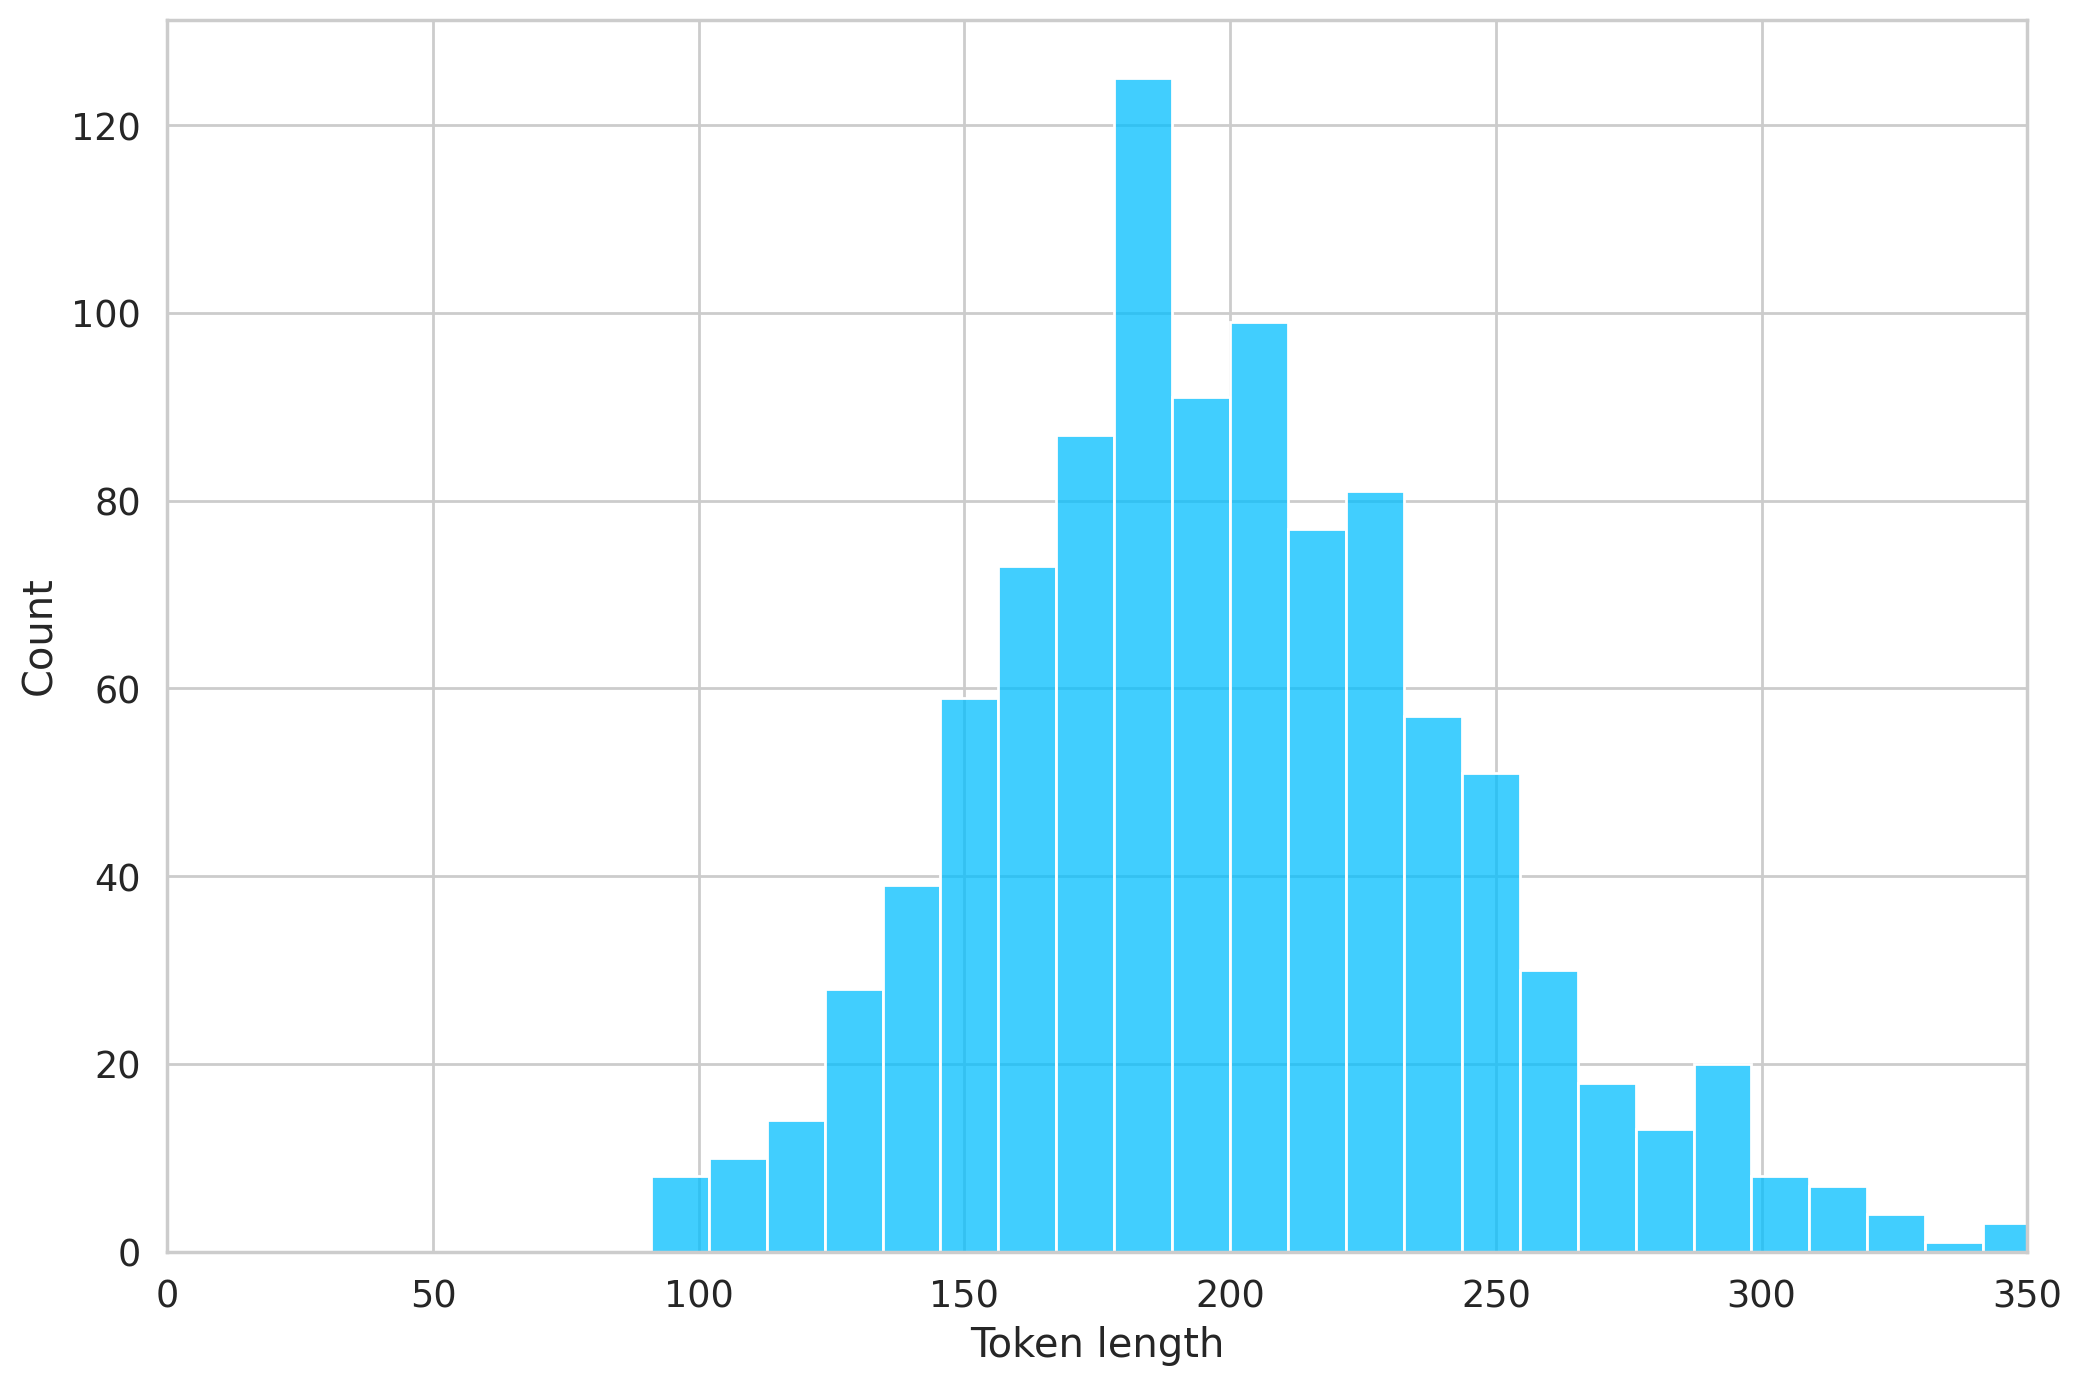

In [30]:
import seaborn as sns
sns.histplot(token_lens)
plt.xlim([0, 350]);
plt.xlabel('Token length');

Most of the tweets seem to contain less than 140 tokens, but we'll be on the safe side and choose a maximum length of 120.

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [31]:
class GPReviewDataset(Dataset):

  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    #target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(self.target[item],dtype=torch.long)
    }

In [32]:
MAX_LEN = 250
BATCH_SIZE = 16


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [33]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [34]:
df_train.shape, df_val.shape, df_test.shape

((906, 2), (50, 2), (51, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    review=df.tweet.to_numpy(),
    target=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

The tokenizer is doing most of the heavy lifting for us. We also return the tweet
texts, so it'll be easier to evaluate the predictions from our model. Let's split the data.

The code splits a our data into three parts: df_train, df_val, and df_test.

df_train This will be a train set that will be used to train the model. It will contain 90% of the original data.
df_test: This is the test set that will be used to evaluate the performance of the model. It will contain 5% of the original data.
df_val: This is the validation set that will be used to tune the hyperparameters of the model. It will contain 5% of the original data.

The importance of splitting the data into three parts is that it allows for more robust evaluation of the model.
The model wil be trained on the training data, and its performance is evaluated on the validation set.
The hyperparameters of the model are then tuned based on the performance on the validation set.
Finally, the model is evaluated on the test set to estimate its performance on unseen data.
Splitting the data into three parts helps to avoid overfitting and to
have a better estimate of the model's generalization performance.

In [36]:

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [37]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/loc

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 250])
torch.Size([16, 250])
torch.Size([16])


### Sentiment Classification with Transformers models and Hugging Face

In [39]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#bert_model = BertModel.from_pretrained("bert-base-uncased")
#bert_model = BertModel.from_pretrained("bert-base-uncased")
#bert_model = RobertaModel.from_pretrained("roberta-base")
#bert_model = AutoConfig.from_pretrained("xlm-roberta-base")
#bert_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base")
#bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL)



model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

And try to use it on the encoding of our sample text:

In [40]:
output = bert_model(
  input_ids=data['input_ids'],
  attention_mask=data['attention_mask']
)
output.last_hidden_state
output.pooler_output

tensor([[ 1.3613e-01, -4.9649e-02,  1.8367e-01,  ..., -1.2939e-01,
          2.3130e-02,  1.1611e-01],
        [ 1.3190e-01,  6.4824e-05,  1.7055e-01,  ..., -1.5282e-01,
          2.1790e-02,  9.7396e-02],
        [ 1.4378e-01, -1.5523e-01,  3.5970e-01,  ..., -2.9228e-01,
          1.8525e-01,  2.2486e-01],
        ...,
        [ 2.0692e-01, -7.3664e-02,  2.4491e-01,  ..., -3.7884e-01,
          1.6598e-01,  2.3949e-01],
        [ 1.3436e-01, -3.7696e-02,  1.3834e-01,  ..., -1.2512e-01,
          1.5187e-02,  1.2874e-01],
        [ 2.0481e-01, -1.3782e-01,  3.0695e-01,  ..., -3.9695e-01,
          1.0873e-01,  1.7844e-01]], grad_fn=<TanhBackward0>)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
#last_hidden_state

In [ ]:
#pooled_output

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [41]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

We can use all of this knowledge to create a classifier that uses the BERT model:

In [42]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-multilingual-cased', return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)


Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [43]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 250])
torch.Size([16, 250])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [45]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3277, 0.3404, 0.3319],
        [0.3300, 0.3407, 0.3293],
        [0.3298, 0.3568, 0.3134],
        [0.3335, 0.3370, 0.3295],
        [0.3317, 0.3370, 0.3313],
        [0.3218, 0.3851, 0.2931],
        [0.3147, 0.3631, 0.3222],
        [0.3212, 0.3327, 0.3462],
        [0.3337, 0.3386, 0.3277],
        [0.3141, 0.3587, 0.3273],
        [0.3231, 0.3448, 0.3321],
        [0.3150, 0.3746, 0.3103],
        [0.3175, 0.3561, 0.3263],
        [0.3189, 0.3741, 0.3070],
        [0.3271, 0.3390, 0.3340],
        [0.3038, 0.3907, 0.3055]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [46]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [47]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [48]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [49]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to

Train loss 1.0838502750062107 accuracy 0.39624724061810157


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 1.0560936033725739 accuracy 0.44

Epoch 2/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.0667199481997574 accuracy 0.4359823399558499


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 1.055808186531067 accuracy 0.42

Epoch 3/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.9917838207462377 accuracy 0.5474613686534217


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.8700086921453476 accuracy 0.6

Epoch 4/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.874086758546662 accuracy 0.6754966887417219


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.8198415637016296 accuracy 0.64

Epoch 5/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.8426528342983179 accuracy 0.7097130242825607


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.8118236809968948 accuracy 0.68

Epoch 6/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.7673201832854957 accuracy 0.7902869757174393


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.7941727787256241 accuracy 0.78

Epoch 7/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.7143436293852957 accuracy 0.8399558498896247


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.7049634456634521 accuracy 0.8

Epoch 8/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6805326708576136 accuracy 0.8741721854304636


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6837348341941833 accuracy 0.84

Epoch 9/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6522888645791171 accuracy 0.9006622516556292


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.684375137090683 accuracy 0.8200000000000001

Epoch 10/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6270840879072223 accuracy 0.9249448123620309


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6656083762645721 accuracy 0.86

Epoch 11/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6166545382717199 accuracy 0.9337748344370861


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6731156557798386 accuracy 0.84

Epoch 12/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.609652066439913 accuracy 0.9426048565121413


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.7025811672210693 accuracy 0.8

Epoch 13/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6038535467365331 accuracy 0.9481236203090507


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6606547087430954 accuracy 0.86

Epoch 14/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5904631478744641 accuracy 0.9613686534216336


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6761464476585388 accuracy 0.84

Epoch 15/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5942998873560053 accuracy 0.9580573951434879


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6723816245794296 accuracy 0.84

Epoch 16/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5876447506118239 accuracy 0.9624724061810155


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6851916462182999 accuracy 0.84

Epoch 17/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5975807256865919 accuracy 0.9525386313465783


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6626023799180984 accuracy 0.86

Epoch 18/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5817050149566249 accuracy 0.9690949227373068


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6614024341106415 accuracy 0.86

Epoch 19/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5826261859191092 accuracy 0.9690949227373068


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.662408858537674 accuracy 0.86

Epoch 20/20
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.579344041514815 accuracy 0.9724061810154525


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6614675372838974 accuracy 0.86

CPU times: user 8min 43s, sys: 4min 41s, total: 13min 25s
Wall time: 14min 26s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

(0.0, 1.0)

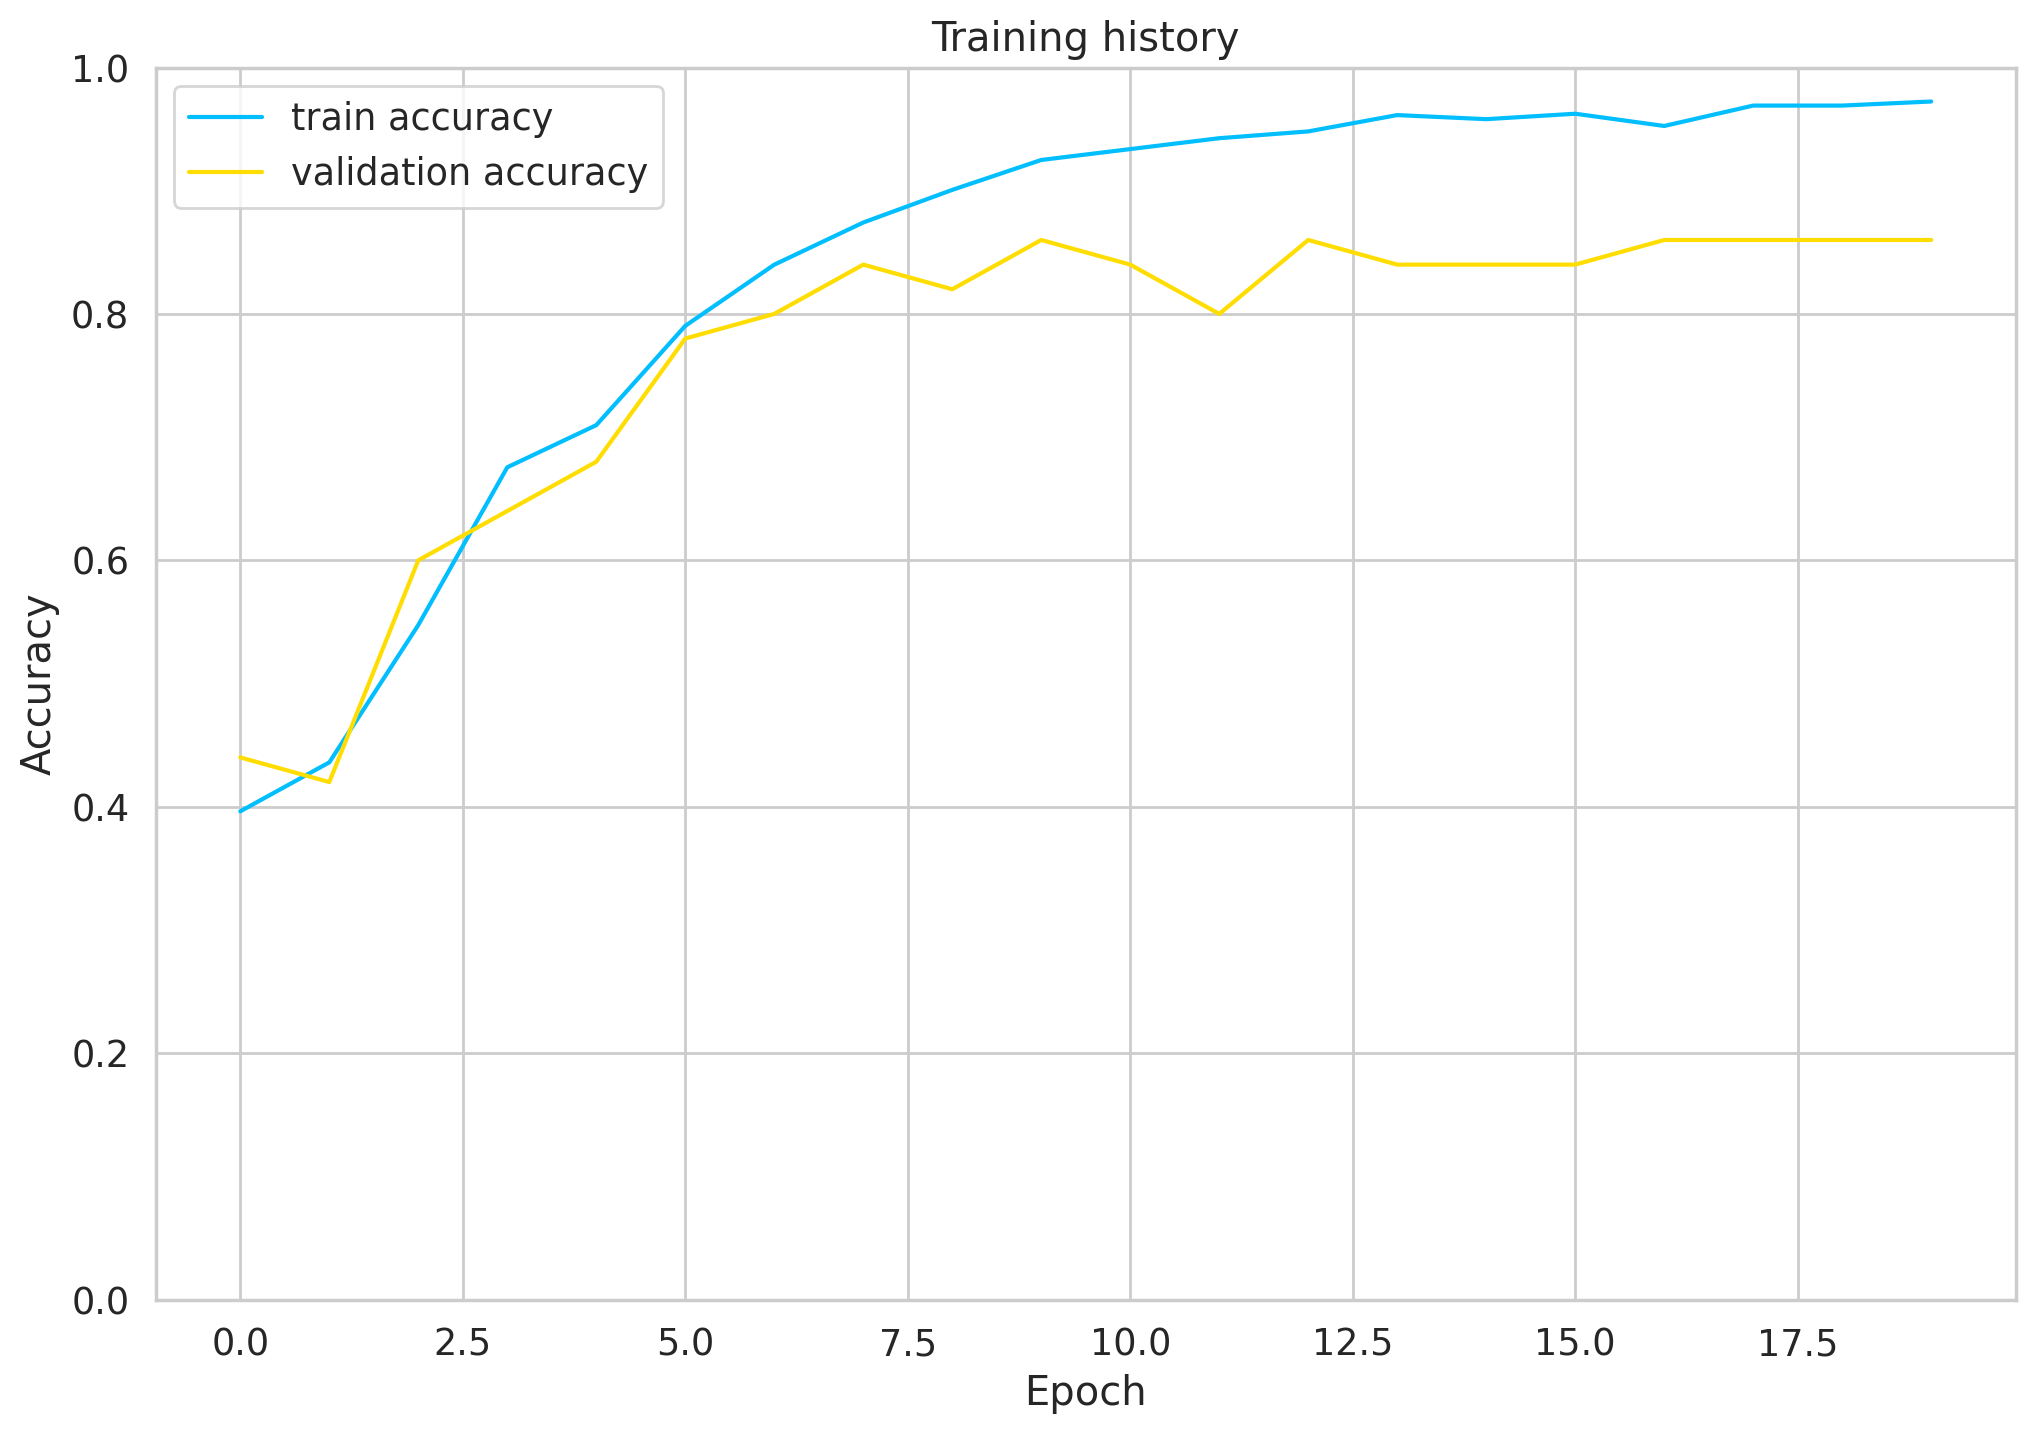

In [50]:
plt.plot([x.cpu() for x in history['train_acc']], label='train accuracy')
plt.plot([x.cpu() for x in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [51]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.8235294117647058

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [52]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [53]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Let's have a look at the classification report

In [54]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83        18
     Neutral       0.71      1.00      0.83        10
    Positive       0.89      0.74      0.81        23

    accuracy                           0.82        51
   macro avg       0.81      0.86      0.83        51
weighted avg       0.84      0.82      0.82        51



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

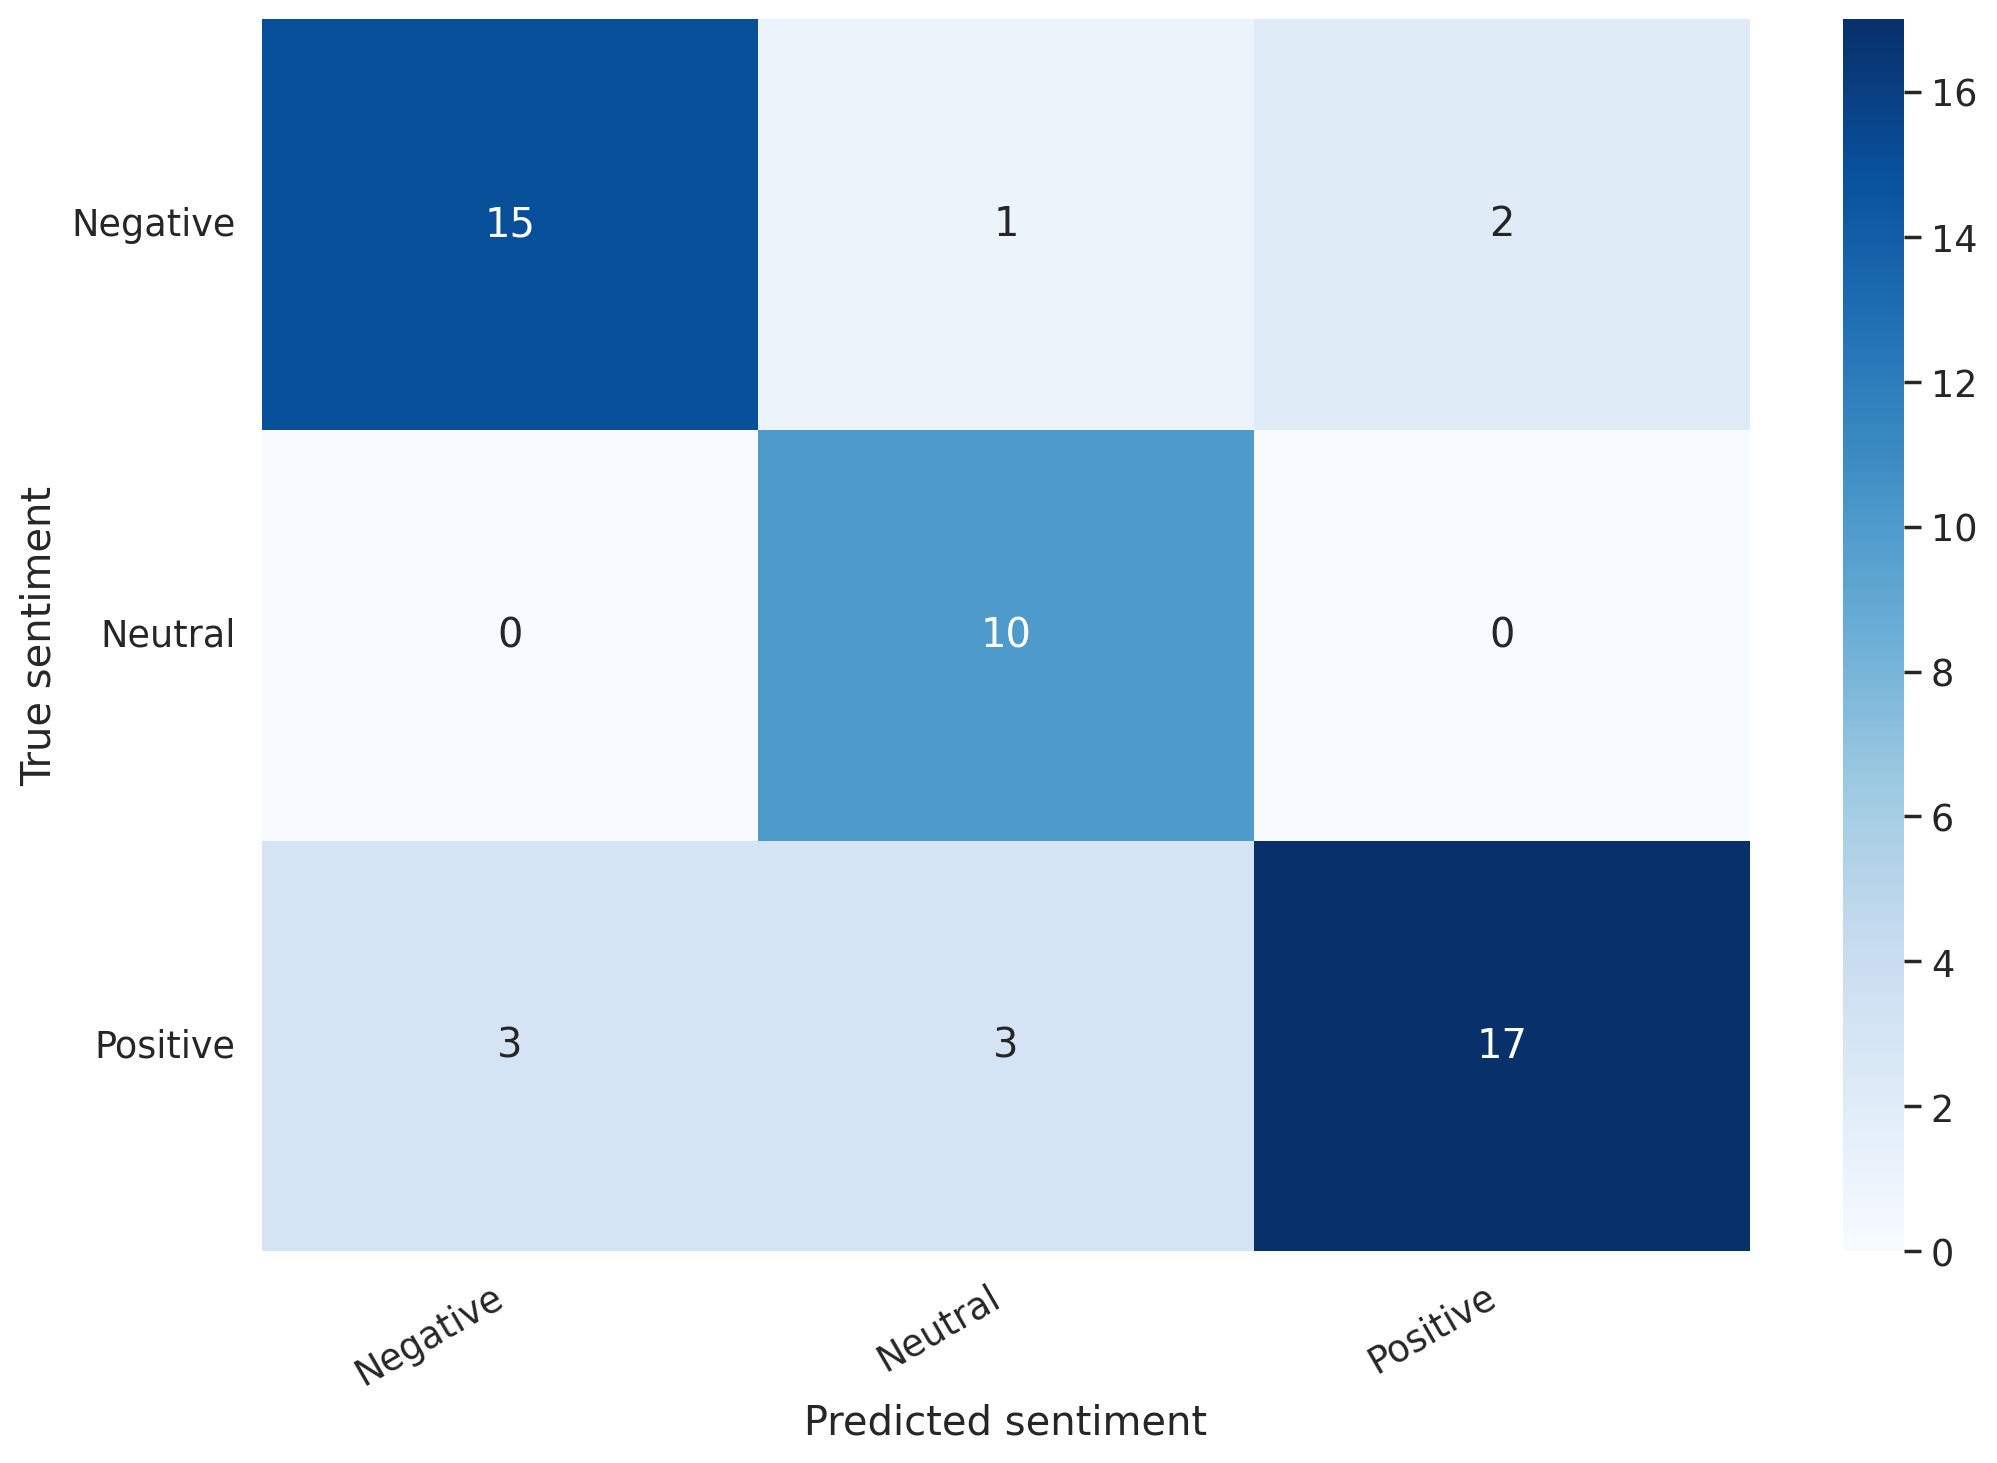

In [55]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [56]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [57]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

আই এম স্টীল কুড  নট বিলিভ দ্যাট  শিরোনামহীন জাস্ট পারফর্ম সারপ্রাইজ
কনসার্ট ইন এ লোকাল ভ্যানু  নসার্টে গান শোনার মুহূর্তগুলো সত্যিই খুব
সুন্দর ছিল  and I feel so lucky to have been there The energy in the
room was electric and  প্রতিটা গানই ছিল  absolutely amazing .   मैं
विश्वास नहीं कर सकता कि मैं इस तरह के विशेष प्रदर्शन को देखने के लिए
कितना भाग्यशाली था। yah nishchit roop se ek aisee raat hai jise  main
kabhee nahin bhooloonga. 🤩#surpriseconcert

True sentiment: Positive


Now we can look at the confidence of each sentiment of our model:

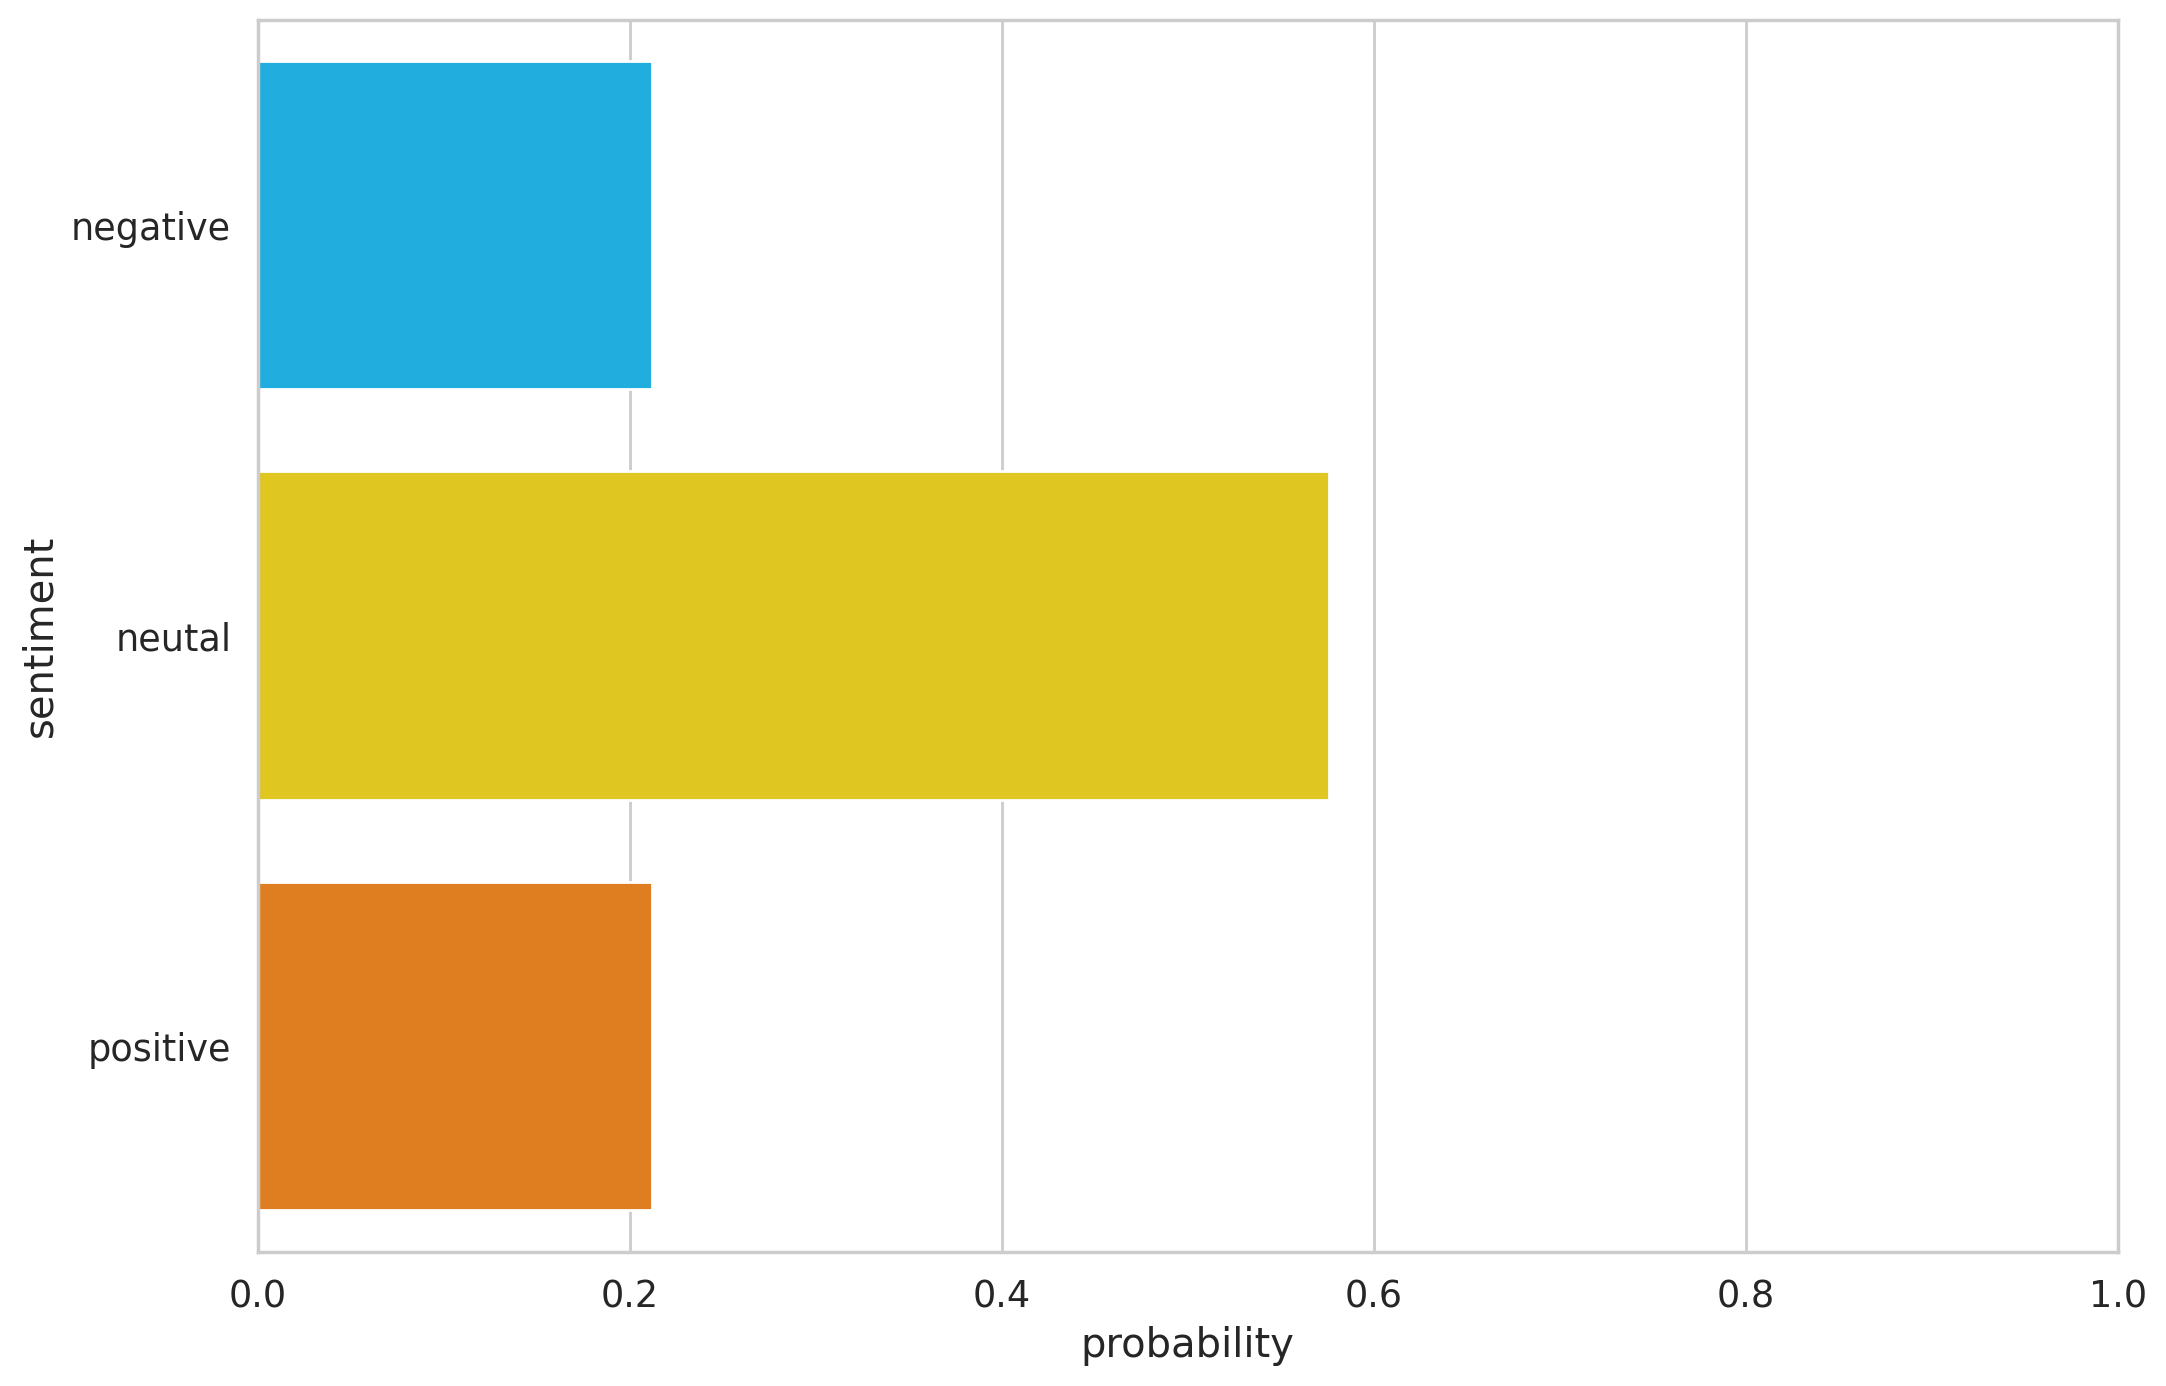

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "@user Aikin banza a banza wawayen mutane 'yan majalisar kasata, wallahì aikin soja guda yafi na duk taronku mi kuke barkatawa talaka a Nigeriar? Kashi 99% cikin dari naku bakuda amfani ga talakawanku wawaye kawai, Allah shi sakawa talakawa akanku😭😭"

In [ ]:

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Let's get the predictions from our model:

In [ ]:

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: @user Aikin banza a banza wawayen mutane 'yan majalisar kasata, wallahì aikin soja guda yafi na duk taronku mi kuke barkatawa talaka a Nigeriar? Kashi 99% cikin dari naku bakuda amfani ga talakawanku wawaye kawai, Allah shi sakawa talakawa akanku😭😭
Sentiment  : negative


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Sentiment analysis with BERT (https://www.youtube.com/watch?v=-CAC4wK9Ey0&list=PLEJK-H61XlwxpfpVzt3oDLQ8vr1XiEhev)]